In [1]:
from os import listdir
from sentence_transformers import CrossEncoder, SentenceTransformer
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoModel
import bm25s
import numpy as np
import torch.nn.functional as F
import torch
import json
import openai
import re
import json
import matplotlib.pyplot as plt

files = listdir('./data')
files.sort()

/home/bvankooten/Documents/Master/Thesis/sentence_transformers/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
files

['BBB.json',
 'CDA.json',
 'CU.json',
 'D66.json',
 'DENK.json',
 'FVD.json',
 'JA21.json',
 'NSC.json',
 'PVDAGL.json',
 'PVDD.json',
 'PVV.json',
 'SGP.json',
 'SP.json',
 'VOLT.json',
 'VVD.json']

In [ ]:
import json

full_data = []

for file in files:
    path = './data/'+ file
    
    with open(path) as f_in:
        full_data.extend(json.load(f_in))

In [5]:
import pandas as pd

df = pd.DataFrame(full_data)

In [6]:
df

,party,statement,summarySentence,paragraphs,references
0,BBB,Inwoners van Nederland moeten een nieuwe wet k...,Zij pleiten ervoor om kaders op te stellen om ...,[[ Het is niet de Grondwet die mensen hun rech...,[Hiervoor moeten kaders worden opgesteld om te...
1,BBB,De regering moet ervoor zorgen dat de hoeveelh...,In plaats daarvan benadrukken ze het belang va...,[[ In wetgeving en aanpassing van regelgeving ...,[We streven in Nederland naar een zorgvuldig e...
2,BBB,De regering moet ervoor zorgen dat de hoeveelh...,Ze benadrukken ook het belang van samenwerking...,[[ In wetgeving en aanpassing van regelgeving ...,"[Nederlandse jagers, landbouwers, vissers, eco..."
3,BBB,"Het minimumloon moet binnen drie jaar van 11,5...",Ze willen ervoor zorgen dat niemand buiten zij...,[[Werk is een van de fundamenten van onze same...,[We zorgen ervoor dat niemand buiten zijn schu...
4,BBB,De overheid moet meer geld geven aan scholen v...,De partij lijkt zich voornamelijk te richten o...,[[ Kinderen moet geleerd worden dat zij meer z...,[Het openhouden van scholen in de regio krijgt...
...,...,...,...,...,...
266,VVD,De huurprijs van woningen mag de komende drie ...,Ze willen de huurprijsstijging remmen en beper...,[[Daarnaast is de woningnood een groot problee...,[We beperken de grootste stijgingen van de hur...
267,VVD,De huurprijs van woningen mag de komende drie ...,Ze willen ook dat huurwoningen voor meer mense...,[[Daarnaast is de woningnood een groot problee...,[▶ We zorgen ervoor dat een huurwoning voor me...
268,VVD,De huurprijs van woningen mag de komende drie ...,Daarnaast willen ze dat verhuurders huurders m...,[[Daarnaast is de woningnood een groot problee...,[We geven verhuurders meer mogelijkheden om il...
269,VVD,"Het minimumloon moet binnen drie jaar van 11,5...",In het eerste citaat staat dat zij het doel st...,[[Dit begint met het meest basale van alles: g...,[We stellen onszelf het doel om werkende armoe...


In [8]:
def handle_nli(data):
    model = CrossEncoder('cross-encoder/nli-roberta-base')
    predictions = []
    for entry in data:
        paragraph_sentences = [item for sublist in entry['paragraphs'] for item in sublist]

        pairs = [(entry['summarySentence'], p) for p in paragraph_sentences]
        scores = model.predict(pairs)

        prediction = []
        for i in range(len(scores)):
            if scores[i][1] > 2:
                prediction.append(paragraph_sentences[i])
        predictions.append(prediction)
    return predictions

def handle_msmarco(data):
    model = CrossEncoder('cross-encoder/ms-marco-MiniLM-L-2-v2')
    predictions = []
    for entry in data:
        paragraph_sentences = [item for sublist in entry['paragraphs'] for item in sublist]

        pairs = [(entry['summarySentence'], p) for p in paragraph_sentences]
        scores = model.predict(pairs)

        prediction = []
        for i in range(len(scores)):
            if scores[i] > 4:
                prediction.append(paragraph_sentences[i])
        predictions.append(prediction)
    return predictions

def handle_bm25(data):
    predictions = []
    for entry in data:
        paragraph_sentences = [item for sublist in entry['paragraphs'] for item in sublist]
        paragraph_tokens = bm25s.tokenize(paragraph_sentences)

        retriever = bm25s.BM25()
        retriever.index(paragraph_tokens)

        query = entry['summarySentence']
        query_tokens = bm25s.tokenize(query)

        results, scores = retriever.retrieve(query_tokens, corpus=paragraph_sentences, k=5)
        
        prediction = []
        for i in range(results.shape[1]):
            if scores[0, i] > 5:
                prediction.append(results[0, i])

        predictions.append(prediction)
    
    return predictions

def handle_e5(data):
    model = SentenceTransformer('intfloat/e5-large-v2')
    predictions = []
    for entry in data:
        input = []
        input.append(f"query: {entry['summarySentence']}")
        input.extend([f'passage: {item}' for sublist in entry['paragraphs'] for item in sublist])
        paragraph_sentences = [item for sublist in entry['paragraphs'] for item in sublist]
        embeddings = model.encode(input, normalize_embeddings=True)
        scores = (embeddings[:1] @ embeddings[1:].T) * 100
        
        prediction = []
        for i in range(len(scores[0])):
            if scores[0][i] > 83:
                prediction.append(paragraph_sentences[i])
        predictions.append(prediction)
        
    return predictions

In [9]:
def format_paragraphs(paragraphs):
    return [''.join(p) for p in paragraphs]

def get_references_messages(summary_sentence, paragraphs):
    sources = 'Bron:\n' + '\n\nBron:\n'.join([p for p in paragraphs])

    prompt = (
        "De volgende bronnen komen uit het verkiezingsprogramma van een politieke partij.\n\n"
        f"{sources}\n\n"
        f"\nDe volgende zin is gebaseerd op de gegeven bronnen: "
        f"\"{summary_sentence}\". Geef aan welke zin of zinnen zijn gebruikt om de volgende zin te maken. Kopieer in je antwoord de volledige zinnen die gebruikt zijn. De referenties bestaan uit maximaal 1 zin. Geef maximaal drie referenties per antwoord. Een referentie is dus echt een enkele zin. Eentje maar, niet meer."
    )

    messages = [{
        "role": "system",
        "content": '''
    Je bent een assistent die bepaald op welke zinnen een gegenereerde zin gebaseerd is. Je doet dit gebaseerd op gegeven bronnen. Een referentie bestaat altijd uit 1 zin, en dus niet meerdere zinnen. Als je twijfelt of een zin een referentie is voor de gegeven zin, voeg hem dan niet toe. Een zin kan ook geen referenties hebben. Elke referentie bestaat uit maximaal 1 zin, en dus niet uit een hele paragraaf. Een referentie is dus echt een enkele zin. Eentje maar, niet meer.
        
    Geef jouw antwoorden terug als een json object. Zorg ervoor dat het antwoord niet te lang wordt. Het is erg belangrijk dat het antwoord uit maximaal 150 tokens bestaat!

    Voorbeeld 1:
    Zin: Ze benadrukken het belang van samenwerking binnen de EU om gezamenlijke uitdagingen aan te gaan, zoals klimaatverandering, migratie en veiligheid.

    Antwoord:
    {
        "zin": "Ze benadrukken het belang van samenwerking binnen de EU om gezamenlijke uitdagingen aan te gaan, zoals klimaatverandering, migratie en veiligheid",
        "references": [
        "Alleen samen vinden we de oplossingen voor de grootste, grenzeloze uitdagingen van deze eeuw, zoals klimaatverandering, digitalisering, migratie en groeiende ongelijkheid.",
        "We werken aan een volwaardige Europese defensie-industrie en vergroten de onderlinge samenwerking tussen defensie-eenheden.",
        "Door samen te werken, samen keuzes te maken over ons klimaat, ons welzijn en onze welvaart, en onze veiligheid, blijft dat ook in de toekomst zo."
        ]
    }

    Voorbeeld 2:
    Zin: Deze partij is tegen de stelling "Nederland moet uit de Europese Unie".

    Antwoord:
    {
        "zin": "Deze partij is tegen de stelling "Nederland moet uit de Europese Unie"",
        "references": []
    }

    Voorbeeld 3:
    Zin: In het verkiezingsprogramma wordt voorgesteld om vermogen eerlijker te belasten door een aparte vermogensbelasting in te voeren op vermogens in box 2 en box 3 boven een miljoen, met een hoger tarief boven de twee miljoen.

    Antwoord:
    {
    "zin": "In het verkiezingsprogramma wordt voorgesteld om vermogen eerlijker te belasten door een aparte vermogensbelasting in te voeren op vermogens in box 2 en box 3 boven een miljoen, met een hoger tarief boven de twee miljoen.",
    "references": [
        "We gaan vermogen eerlijker belasten.",
        "We voeren daarnaast een aparte vermogensbelasting in op vermogens in box 2 en box 3 boven een miljoen, met een hoger tarief boven de twee miljoen."
    ]
}

    '''
    },
        {
            "role": "user",
            "content": prompt
        }
    ]

    return messages

In [12]:
def handle_gpt(data):
    predictions = []
    for entry in data:
        messages = get_references_messages(
            summary_sentence=entry['summarySentence'],
            paragraphs=format_paragraphs(entry['paragraphs'])
        )
        completion = openai.chat.completions.create(
            # model="gpt-3.5-turbo-0125",
            model="gpt-4-turbo-2024-04-09",
            messages=messages,
            response_format={"type": "json_object"},
            temperature=0.0,
            max_tokens=512,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            timeout=30
        )
        try:
            json_response = json.loads(completion.choices[0].message.content)
            predictions.append(json_response['references'])
        except ValueError:
            print(completion.choices[0].message.content)
            predictions.append([])
    return predictions

In [10]:
statements = [
    "De regering moet ervoor zorgen dat de hoeveelheid vee minstens de helft kleiner wordt.",
    "De accijns op benzine, gas en diesel moet omlaag.",
    "Het eigen risico bij zorgverzekeringen moet worden afgeschaft.",
    "Elke regio in Nederland moet een vast aantal mensen in de Tweede Kamer krijgen.",
    "Mensen vanaf 65 jaar moeten gratis met trein, tram en bus kunnen reizen.",
    "De regering moet meer investeren in opslag van CO2 onder de grond.",
    "De regering moet ervoor zorgen dat Surinamers zonder visum naar Nederland kunnen reizen.",
    "Er moet een wet komen waarin staat dat Nederland altijd 2% van het bruto binnenlands product uitgeeft aan defensie.",
    "De overheid moet meer geld geven aan scholen voor lessen in kunst en cultuur.",
    "In Nederland moeten meer kerncentrales komen.",
    "De belasting op vliegreizen moet omhoog.",
    "Huurders moeten het recht krijgen om hun sociale huurwoning te kopen van de wooncorporaties.",
    "Kinderopvang mag alleen worden aangeboden door organisaties die geen winst maken.",
    "Als een vluchteling in Nederland mag blijven, mag het gezin nu naar Nederland komen. De regering moet dat beperken.",
    "De belasting op vermogen boven 57.000 euro moet omhoog.",
    "De overheid moet strenger controleren wat jongeren leren bij kerken, moskeeën en andere organisaties die les geven op basis van een levensbeschouwing.",
    "De regering moet ervoor zorgen dat er in 2030 minstens de helft minder stikstof in de lucht komt.",
    "Als je recht hebt op een uitkering en je woont samen, moet je hetzelfde bedrag krijgen als wanneer je alleen woont.",
    "De regering moet zich ertegen verzetten dat meer landen lid worden van de Europese Unie.",
    "De overheid mag nooit de afkomst of nationaliteit van mensen gebruiken om risico’s op criminaliteit in te schatten.",
    "De overheid moet geen geld meer geven aan mensen om een elektrische auto te kopen.",
    "Het minimumloon moet binnen drie jaar van 11,51 euro bruto per uur naar 16 euro bruto per uur.",
    "De regering moet het bouwen van woonwijken op landbouwgrond gemakkelijker maken.",
    "Inwoners van Nederland moeten een nieuwe wet kunnen tegenhouden met een referendum.",
    "De regering moet het afsteken van vuurwerk door particulieren helemaal verbieden.",
    "De overheid moet bedrijven minder geld geven om duurzamer te worden.",
    "Mensen die vinden dat ze klaar zijn met hun leven, moeten hulp kunnen krijgen bij zelfdoding.",
    "Nederland moet geen ontwikkelingshulp geven aan landen die weigeren uitgeprocedeerde asielzoekers terug te nemen.",
    "De huurprijs van woningen mag de komende drie jaar niet stijgen.",
    "Er moeten minimumstraffen komen voor mensen die zwaar geweld gebruiken.",
  ]
parties = ["Volt", "PVDAGL", "NSC", "JA21", "BBB", "VVD", "SP", "SGP", "PVV", "PVDD", "FVD", "DENK", "CU", "CDA", "D66"]

parties.sort()

In [11]:
def split_sentence(sentence):
    result = re.sub(r'([.?!])\s*(?=\S)', r'\1|', sentence).split('|')
    return result

def split_results(predictions):
    predictions_new = []
    for pred in predictions:
        pred_new = [split_sentence(ref) for ref in pred]
        predictions_new.append([x for xs in pred_new for x in xs])
    return predictions_new

In [ ]:
with open('results/msmarco.json') as f:
    predictions_msmarco = json.load(f)

with open('results/bm25.json') as f:
    predictions_bm25 = json.load(f)

with open('results/nli.json') as f:
    predictions_nli = json.load(f)

with open('results/e5.json') as f:
    predictions_e5 = json.load(f)

with open('results/gpt.json') as f:
    predictions_gpt = split_results(json.load(f))

with open('results/gpt-4.json') as f:
    predictions_gpt_4 = split_results(json.load(f))

df2 = df.assign(msmarco=predictions_msmarco)
df2 = df2.assign(bm25=predictions_bm25)
df2 = df2.assign(nli=predictions_nli)
df2 = df2.assign(e5=predictions_e5)
df2 = df2.assign(gpt=predictions_gpt)
df2 = df2.assign(gpt_4=predictions_gpt_4)

In [14]:
def precision(row, row_name):
    y_true = set(map(str.strip, row['references']))
    pred = set(map(str.strip, row[row_name]))
    intersection = pred.intersection(y_true)
    if len(pred) == 0:
        return None
    else:
        return len(intersection) / len(pred)

def recall(row, row_name):
    y_true = set(map(str.strip, row['references']))
    pred = set(map(str.strip, row[row_name]))
    intersection = pred.intersection(y_true)
    if len(y_true) == 0:
        return None
    else:
        return len(intersection) / len(y_true)
    
def f1(row, row_name):
    p = row[f"{row_name}_precision"] if row[f"{row_name}_precision"] else 0
    r = row[f"{row_name}_recall"] if row[f"{row_name}_recall"] else 0

    if not (p == 0 and r == 0):
        return (2*p*r) / (p + r)
    else:
        return None

In [27]:
def average_precision(col):
    return round(np.nansum(col) / len(col), 3)

def average_recall(col):
    return round(np.nansum(col) / len(col), 3)

def average_f1(col):
    return round(np.nansum(col) / len(col), 3)

In [20]:
df2['msmarco_precision'] = df2.apply(lambda row: precision(row, 'msmarco'), axis=1)
df2['msmarco_recall'] = df2.apply(lambda row: recall(row, 'msmarco'), axis=1)
df2['msmarco_f1'] = df2.apply(lambda row: f1(row, 'msmarco'), axis=1)

df2['bm25_precision'] = df2.apply(lambda row: precision(row, 'bm25'), axis=1)
df2['bm25_recall'] = df2.apply(lambda row: recall(row, 'bm25'), axis=1)
df2['bm25_f1'] = df2.apply(lambda row: f1(row, 'bm25'), axis=1)

df2['nli_precision'] = df2.apply(lambda row: precision(row, 'nli'), axis=1)
df2['nli_recall'] = df2.apply(lambda row: recall(row, 'nli'), axis=1)
df2['nli_f1'] = df2.apply(lambda row: f1(row, 'nli'), axis=1)

df2['e5_precision'] = df2.apply(lambda row: precision(row, 'e5'), axis=1)
df2['e5_recall'] = df2.apply(lambda row: recall(row, 'e5'), axis=1)
df2['e5_f1'] = df2.apply(lambda row: f1(row, 'e5'), axis=1)

df2['gpt_precision'] = df2.apply(lambda row: precision(row, 'gpt'), axis=1)
df2['gpt_recall'] = df2.apply(lambda row: recall(row, 'gpt'), axis=1)
df2['gpt_f1'] = df2.apply(lambda row: f1(row, 'gpt'), axis=1)

df2['gpt_4_precision'] = df2.apply(lambda row: precision(row, 'gpt_4'), axis=1)
df2['gpt_4_recall'] = df2.apply(lambda row: recall(row, 'gpt_4'), axis=1)
df2['gpt_4_f1'] = df2.apply(lambda row: f1(row, 'gpt_4'), axis=1)

In [29]:
print('Model Precision Recall F1')
print('MSMARCO', average_precision(list(df2['msmarco_precision'])),average_recall(list(df2['msmarco_recall'])), average_f1(list(df2['msmarco_f1'])))
print('BM25', average_precision(list(df2['bm25_precision'])), average_recall(list(df2['bm25_recall'])), average_f1(list(df2['bm25_f1'])))
print('NLI', average_precision(list(df2['nli_precision'])), average_recall(list(df2['nli_recall'])), average_f1(list(df2['nli_f1'])))
print('E5', average_precision(list(df2['e5_precision'])), average_recall(list(df2['e5_recall'])), average_f1(list(df2['e5_f1'])))
print('GPT', average_precision(list(df2['gpt_precision'])), average_recall(list(df2['gpt_recall'])), average_f1(list(df2['gpt_f1'])))
print('GPT-4', average_precision(list(df2['gpt_4_precision'])), average_recall(list(df2['gpt_4_recall'])), average_f1(list(df2['gpt_4_f1'])))

Model Precision Recall F1
MSMARCO 0.625 0.631 0.59
BM25 0.672 0.762 0.679
NLI 0.372 0.319 0.327
E5 0.393 0.83 0.468
GPT 0.424 0.661 0.487
GPT-4 0.649 0.655 0.641


In [ ]:
with open('results/e5_embeddings.json') as f:
    e5_embeddings = json.load(f)

e5_embeddings = [np.asarray(e) for e in e5_embeddings]

In [25]:
scores = []

for embedding in e5_embeddings:
    score = (embedding[:1] @ embedding[1:].T) * 100
    scores.append(score)

In [33]:
def precision_threshold(references, prediction):
    y_true = set(map(str.strip, references))
    pred = set(map(str.strip, prediction))
    intersection = pred.intersection(y_true)
    if len(pred) == 0:
        return None
    else:
        return len(intersection) / len(pred)

def recall_threshold(references, prediction):
    y_true = set(map(str.strip, references))
    pred = set(map(str.strip, prediction))
    intersection = pred.intersection(y_true)
    if len(y_true) == 0:
        return None
    else:
        return len(intersection) / len(y_true)

In [27]:
thresholds = np.arange(69.11, 95.85, 0.01)

In [28]:
def compute_avg(avg):
    values = np.asarray(avg)
    prec = [p if p else 0 for p in values[:,0]]
    rec = [r if r else 0 for r in values[:,1]]
    return [np.mean(prec), np.mean(rec)]

In [34]:
avgs = []
for threshold in thresholds:
    avg = []
    for n in range(len(full_data)):
        prediction = []
        paragraph_sentences = [item for sublist in full_data[n]['paragraphs'] for item in sublist]
        for i in range(len(scores[n][0])):
            if scores[n][0][i] > threshold:
                prediction.append(paragraph_sentences[i])
        avg.append([precision_threshold(full_data[n]['references'], prediction), recall_threshold(full_data[n]['references'], prediction)])
    avgs.append({'threshold': threshold, 'avg': compute_avg(avg)})

In [35]:
prec = []
rec = []
for a in avgs:
    prec.append(a['avg'][0])
    rec.append(a['avg'][1])

In [36]:
max_prec = max(prec)
for a in avgs:
    if a['avg'][0] == max_prec:
        print('Threshold:', a['threshold'], 'Precision', a['avg'][0], 'Recall', a['avg'][1])

Threshold: 86.14000000000871 Precision 0.6505535055350554 Recall 0.6039360393603935
Threshold: 86.15000000000872 Precision 0.6505535055350554 Recall 0.6039360393603935


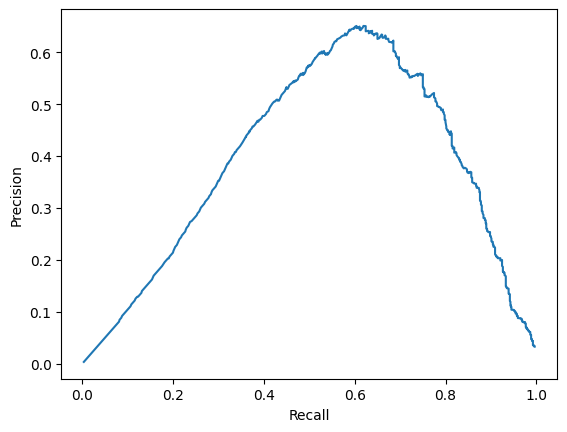

In [37]:
plt.plot(rec,prec)
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.savefig('Prec-rec-E5.pdf')

In [31]:
for party in parties:
    df_party = df2.loc[df2['party'] == party]
    print(party)
    print('Model Precision Recall F1')
    print('MSMARCO', average_precision(list(df_party['msmarco_precision'])),average_recall(list(df_party['msmarco_recall'])), average_f1(list(df_party['msmarco_f1'])))
    print('BM25', average_precision(list(df_party['bm25_precision'])), average_recall(list(df_party['bm25_recall'])), average_f1(list(df_party['bm25_f1'])))
    print('NLI', average_precision(list(df_party['nli_precision'])), average_recall(list(df_party['nli_recall'])), average_f1(list(df_party['nli_f1'])))
    print('E5', average_precision(list(df_party['e5_precision'])), average_recall(list(df_party['e5_recall'])), average_f1(list(df_party['e5_f1'])))
    print('GPT', average_precision(list(df_party['gpt_precision'])), average_recall(list(df_party['gpt_recall'])), average_f1(list(df_party['gpt_f1'])))
    print('GPT-4', average_precision(list(df_party['gpt_4_precision'])), average_recall(list(df_party['gpt_4_recall'])), average_f1(list(df_party['gpt_4_f1'])))
    print('')

BBB
Model Precision Recall F1
MSMARCO 0.417 0.464 0.393
BM25 0.586 0.798 0.644
NLI 0.107 0.143 0.119
E5 0.604 0.81 0.617
GPT 0.538 0.786 0.6
GPT-4 0.643 0.679 0.648

CDA
Model Precision Recall F1
MSMARCO 0.647 0.603 0.597
BM25 0.487 0.659 0.519
NLI 0.19 0.159 0.159
E5 0.389 0.786 0.485
GPT 0.304 0.492 0.357
GPT-4 0.425 0.532 0.464

CU
Model Precision Recall F1
MSMARCO 0.671 0.675 0.615
BM25 0.699 0.792 0.725
NLI 0.525 0.408 0.437
E5 0.225 0.725 0.298
GPT 0.435 0.592 0.479
GPT-4 0.638 0.6 0.608

D66
Model Precision Recall F1
MSMARCO 0.596 0.683 0.606
BM25 0.621 0.775 0.658
NLI 0.275 0.275 0.275
E5 0.313 0.858 0.397
GPT 0.474 0.683 0.523
GPT-4 0.775 0.808 0.787

DENK
Model Precision Recall F1
MSMARCO 0.266 0.219 0.212
BM25 0.578 0.438 0.467
NLI 0.5 0.292 0.354
E5 0.565 0.75 0.602
GPT 0.422 0.667 0.495
GPT-4 0.698 0.656 0.671

FVD
Model Precision Recall F1
MSMARCO 0.438 0.438 0.417
BM25 0.625 0.688 0.646
NLI 0.438 0.438 0.417
E5 0.505 0.875 0.599
GPT 0.247 0.688 0.34
GPT-4 0.417 0.562 0.4

In [32]:
for party in parties:
    df_party = df2.loc[df2['party'] == party]
    print(party, df_party.shape[0])

BBB 14
CDA 21
CU 20
D66 20
DENK 16
FVD 8
JA21 28
NSC 15
PVDAGL 28
PVDD 23
PVV 14
SGP 12
SP 11
VVD 20
Volt 21
